[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/kadenze-deeplearning-creative-applications/blob/master/Kadenze_Session_3.ipynb)

In [0]:
%matplotlib inline
#%pylab

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.style.use('ggplot')

In [2]:
!git clone https://github.com/JacksonIsaac/CADL.git
!mv CADL/session-3/* .

fatal: destination path 'CADL' already exists and is not an empty directory.
mv: cannot stat 'CADL/session-3/*': No such file or directory


In [0]:
from libs.utils import montage
from libs import gif
from libs.datasets import MNIST

In [4]:
ds = MNIST()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
ds.X.shape

(70000, 784)

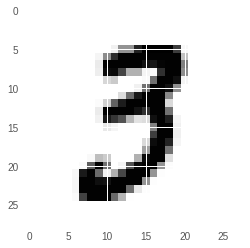

In [6]:
plt.imshow(ds.X[0].reshape((28,28)))

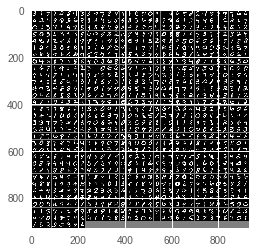

In [7]:
imgs = ds.X[:1000].reshape((-1, 28, 28))
plt.imshow(montage(imgs), cmap='gray')

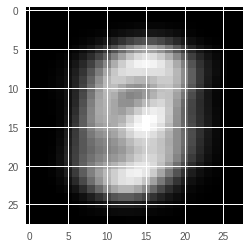

In [8]:
mean_img = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

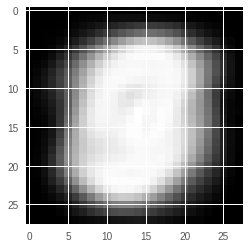

In [9]:
std_img = np.std(ds.X, axis=0)
plt.figure()
plt.imshow(std_img.reshape((28, 28)), cmap='gray')

In [0]:
dimensions = [512, 256, 128, 64]

In [11]:
n_features = ds.X.shape[1]

## [None, n] means that it can have any no of rows m
X = tf.placeholder(tf.float32, [None, n_features])

current_input = X
n_input = n_features


## For decoder
Ws = []

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        
        W = tf.get_variable(
            name = 'W',
            shape = [n_input, n_output],
            initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws = Ws[::-1]

dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]

print(dimensions)

## Encoder

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        
        W = tf.transpose(Ws[layer_i])
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output

[128, 256, 512, 784]


In [12]:
Y = current_input

cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

print(cost.get_shape())

(?,)


0 0.04279111
1 0.03740512
2 0.034859464
3 0.03384537
4 0.032185882
5 0.03110287
6 0.030172765
7 0.030269137
8 0.02976014
9 0.02953837
10 0.027878974
11 0.028379247
12 0.028334288
13 0.02760704
14 0.028029695
15 0.027584836
16 0.027198365
17 0.026143175
18 0.027103595
19 0.027237976
20 0.02783323
21 0.026365312
22 0.027190402
23 0.026908167
24 0.026470141
25 0.026990173
26 0.02633938
27 0.026179476
28 0.026816728
29 0.025766416
30 0.025012203
31 0.02590006
32 0.026297286
33 0.026052928
34 0.02610659
35 0.025648886
36 0.026407972
37 0.0264386
38 0.025899963
39 0.02558515
40 0.025314722
41 0.02555488
42 0.02514942
43 0.025502607
44 0.025744107
45 0.025095165
46 0.02541878
47 0.026013853
48 0.025695637
49 0.02575802
50 0.024589958
51 0.02509557
52 0.024353208
53 0.026049554
54 0.02491096
55 0.025339603
56 0.025246069
57 0.025372481
58 0.024775743
59 0.024903137
60 0.024343446
61 0.025354264
62 0.025346264
63 0.024499504
64 0.025234623
65 0.024786513
66 0.02531457
67 0.025285415
68 0.024282

/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: ignored

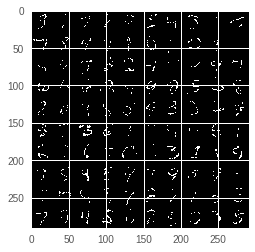

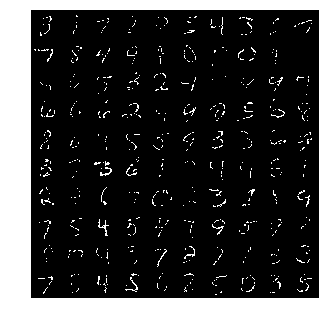

In [14]:
cost = tf.reduce_mean(cost)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

batch_size = 100
n_epochs = 100

examples = ds.X[:100]

imgs = []

fig, ax = plt.subplots(1,1)

for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28,28)), 0, 255)
    
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    
    ax.imshow(img_i, cmap='gray')
    
    fig.canvas.draw()
    
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
    
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [15]:
import IPython.display as ipyd
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [0]:
from tensorflow.python.framework.ops import reset_default_graph

In [0]:
reset_default_graph()

In [28]:
X = tf.placeholder(tf.float32, [None, n_features])

## Reshape placeholder to 4d for convolutional input
## Batch dimension will be filled in place of -1 and
## the shape of the image remains constant.
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

n_filters = [16, 16, 16]
filter_size = [4, 4, 4]

current_input = X_tensor

n_input = 1 # Number of channels in an image

# Will use convolution to find 16 filters/channels of information
Ws = []
shapes = []

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(
            name='W',
            shape=[
                filter_size[layer_i], # height
                filter_size[layer_i], # width
                n_input, # No. of input channels
                n_output # No. of output channels
            ],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        # [1, 2, 2, 1]
        # [batch_dimension, next height, next width, #channel]
        # Take every image. Apply to every other height and width. 
        # Apply to every channel.
        
        h = tf.nn.conv2d(current_input, W, strides=[1, 2, 2, 1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws.reverse()
shapes.reverse()
n_filters.reverse()

n_filters = n_filters[1:] + [1]

print(n_filters, filter_size, shapes)

for layer_i, shape in enumerate(shapes):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        W = Ws[layer_i]
        
        h = tf.nn.conv2d_transpose(
            current_input, W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME'
        )
        
        current_input = tf.nn.relu(h)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


0 0.026844492
1 0.025554216
2 0.025352437
3 0.024718065
4 0.025983749
5 0.025308141
6 0.024075042
7 0.023643197
8 0.023709945
9 0.024302058
10 0.024283497
11 0.024028117
12 0.024721432
13 0.024418565
14 0.023546306
15 0.02450718
16 0.024654841
17 0.023958411
18 0.024228882
19 0.023597052
20 0.023827331
21 0.024427956
22 0.024387086
23 0.023331387
24 0.023769269
25 0.022806099
26 0.024007969
27 0.023786802
28 0.023718394
29 0.024340322
30 0.024063509
31 0.0240895
32 0.023865046
33 0.023669591
34 0.023713306
35 0.024459194
36 0.022769056
37 0.02382164
38 0.024916677
39 0.023901664
40 0.02319762
41 0.023602832
42 0.024451964
43 0.0232032
44 0.023763012
45 0.023716167
46 0.023582112
47 0.02401094
48 0.023276484
49 0.023732746
50 0.023866117
51 0.023421906
52 0.023570698
53 0.02424761
54 0.023337021
55 0.02352902
56 0.023583781
57 0.023782648
58 0.023901206
59 0.024200115
60 0.023388175
61 0.02294472
62 0.023867302
63 0.023477433
64 0.023146197
65 0.023758989
66 0.023969745
67 0.023089033
6

/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: ignored

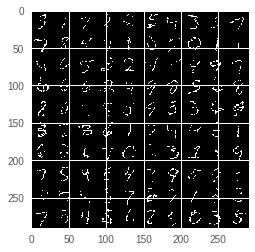

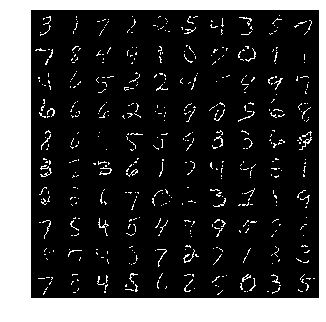

In [29]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()

sess.run(tf.initialize_all_variables())

batch_size = 100
n_epoch = 100

examples = ds.X[:100]

imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')